IndexError: pop index out of range

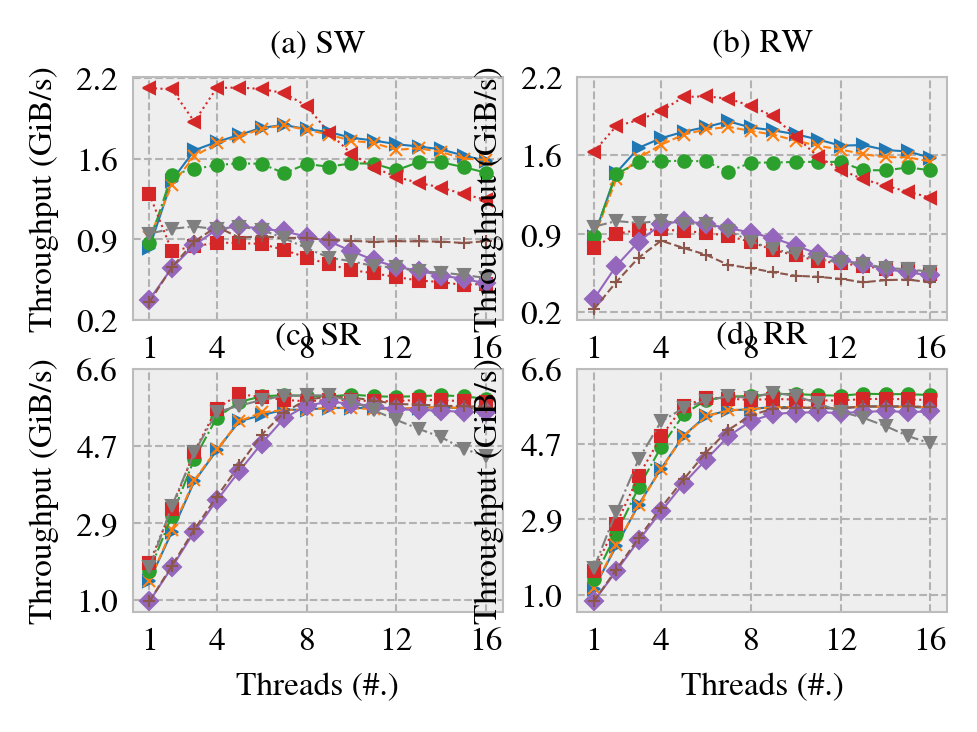

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('bmh')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-"]
subtitles = ["(a) SW", "(b) RW", "(c) SR", "(d) RR"]
sort_dict = {
    "NOVA" : 0, 
    "NOVA-RELAX": 1,
    "PMFS": 2,
    "KILLER" : 8,  
    "SplitFS-FIO" :4, 
    "EXT4-DAX" : 5,  
    "XFS-DAX": 6,
    "KILLER-NO-MT-OPT": 3,
    "MadFS": 7,
}
sort_df = pd.DataFrame(df['file_system'].map(sort_dict))
sort_df["job"] = df['job']
df = df.iloc[sort_df.sort_values(by = ["file_system", "job"]).index]

fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
# fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
num_jobs = list(range(1, 17))
def zoom_in(ax, axins, x_ratio, y_ratio, x_start, y_start, 
            zoom_height, zoom_style,
            connect_ax_first_loc, connect_ax_second_loc, connect_axins_first_loc, connect_axins_second_loc, 
            axins_x0, axins_y0):
    # 1: 左上, 2: 左下, 3: 右上, 4: 右下
    x_lim_left, x_lim_right = ax.get_xlim()
    y_lim_left, y_lim_right = ax.get_ylim()

    xlim_left = x_start
    xlim_right = x_start + x_ratio * (x_lim_right - x_lim_left)
    ylim_left = y_start
    ylim_right = y_start + y_ratio * (y_lim_right - y_lim_left)

    axins.set_xlim(xlim_left, xlim_right)
    axins.set_ylim(ylim_left, ylim_right)

    zoom_xlim_left = xlim_left
    zoom_xlim_right = xlim_right
    zoom_ylim_left = ylim_left - zoom_height * (y_lim_right - y_lim_left)
    zoom_ylim_right = ylim_right + zoom_height * (y_lim_right - y_lim_left)
    
    ax.plot([zoom_xlim_left, zoom_xlim_right, zoom_xlim_right, zoom_xlim_left, zoom_xlim_left], 
            [zoom_ylim_left, zoom_ylim_left, zoom_ylim_right, zoom_ylim_right, zoom_ylim_left], 
            color='k', lw=0.5, zorder=2)
    
    def get_ax_connect_point(connect_loc):
        if connect_loc == 1:
            return (zoom_xlim_left, zoom_ylim_right)
        elif connect_loc == 2:
            return (zoom_xlim_left, zoom_ylim_left)
        elif connect_loc == 3:
            return (zoom_xlim_right, zoom_ylim_right)
        elif connect_loc == 4:
            return (zoom_xlim_right, zoom_ylim_left)
        
    def get_axins_connect_point(connect_loc):
        if connect_loc == 1:
            return (xlim_left, ylim_right)
        elif connect_loc == 2:
            return (xlim_left, ylim_left)
        elif connect_loc == 3:
            return (xlim_right, ylim_right)
        elif connect_loc == 4:
            return (xlim_right, ylim_left)

    if zoom_style == "line":
        xy = get_ax_connect_point(connect_ax_first_loc)
        xy2 = get_axins_connect_point(connect_axins_first_loc)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax, lw=0.5, linestyle=(0, (3, 3)), color="black")
        axins.add_artist(con)

        xy = get_ax_connect_point(connect_ax_second_loc)
        xy2 = get_axins_connect_point(connect_axins_second_loc)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax, lw=0.5, linestyle=(0, (3, 3)), color="black")
        
        axins.add_artist(con)

    elif zoom_style == "arrow":
        left_margin = zoom_xlim_left + 0.2 * (zoom_xlim_right - zoom_xlim_left)
        # get y pos of axins
        lower_y = y_lim_left + axins_y0 * (y_lim_right - y_lim_left)
        arrow_length = lower_y - zoom_ylim_right
        gap = 0.15 * arrow_length
        
        # draw an arrow from ax to axins
        ax.arrow(left_margin, zoom_ylim_right + gap, 
                 0, arrow_length - 2 * gap,
                 length_includes_head=True,
                 head_width=0.03 * (x_lim_right - x_lim_left), 
                 head_length=0.05 * (y_lim_right - y_lim_left),
                 fc='k', ec='k', linewidth=0.8)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
lines = []
cmap = "tab10"
for op_idx, op in enumerate(ops):
    subfig = plt.subplot(2, 2, op_idx + 1)
    # subfig = plt.subplot(gs0[op_idx])
    for idx, fs in enumerate(fss):
        if fs == "KILLER":
            if op == "seq-read" or op == "rnd-read":
                continue
            
        if fs == "KILLER-NO-MT-OPT":
            line, = plt.plot(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(3), markerfacecolor=plt.get_cmap(cmap)(3), linewidth= line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx], zorder=11)
        elif fs == "KILLER":
            line, = plt.plot(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(3), markerfacecolor=plt.get_cmap(cmap)(3), linewidth= line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx], zorder=10)
        else:
            if fs == "MadFS":
                color_idx = idx + 1
            else:
                color_idx = idx
            line, = plt.plot(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(color_idx), markerfacecolor=plt.get_cmap(cmap)(color_idx), linewidth= line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
        
        # plt.scatter(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), s=0.1)
        lines.append(line)

    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    plt.xticks([1, 4, 8, 12, 16], labels=[1, 4, 8, 12, 16], fontsize=8)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    # if op_idx == 0:
    #     plt.ylabel('Throughput (GiB/s)', fontsize=8)
    if op_idx == 0 or op_idx == 1:
        plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
    else:
        plt.yticks(np.linspace(1, 6.6, 4), fontsize=8)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    # subfig.text(0.5, -0.3, "Threads (#.)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
    plt.xlabel("Threads (#.)", fontsize=8) 
    plt.title(subtitles[op_idx], fontsize=8, loc='center')
    plt.ylabel('Throughput (GiB/s)', fontsize=8)
    # if op_idx == 0 or op_idx == 2:

    # if op.count("read") != 0:
    #     axins = subfig.inset_axes((0.45, 0.12, 0.5, 0.6))    
    #     for idx, fs in enumerate(fss):
    #         axins.plot(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth= line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
    #     axins.set_xlim(2.5, 4.5)
    #     axins.set_ylim(4, 5)
    #     axins.set_yticks([4, 5, 6])
    #     axins.set_yticklabels([])
    #     axins.set_xticks([3, 4])
    #     axins.set_xticklabels(["3", "4"], fontsize=8)
    #     axins.tick_params(bottom=False, top=False, left=False, right=False)
    #     lw = 0.5
    #     for axis in ['top','bottom','left','right']:
    #         axins.spines[axis].set_linewidth(lw)
    #         axins.spines[axis].set_color('k')
    #     # zoom_in(ax, axins, )
    #     zoom_in(ax, axins, 1/8, 2/5.6, 2.5, 3.5, 0.1, "line", 3, 2, 3, 2, 0.5, 0.5)
    #     # mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='k', lw=0.5)
        
fss.replace("SplitFS-FIO", "SplitFS", inplace=True)
fss.replace("KILLER", "WOLVES-bwr", inplace=True)
fss.replace("KILLER-NO-MT-OPT", "WOLVES", inplace=True)
# fig.legend(lines, fss, loc='center', bbox_to_anchor=(0.5, 1.01), ncol=4, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)
steps = [0, 0, 5, 4]
lines.insert(4, lines.pop(8))
fss = list(fss)
fss.insert(4, fss.pop(8))
for ax_id, ax in enumerate(fig.axes):
    start = sum(steps[:ax_id])
    end = start + steps[ax_id]

    if end == start:
        continue
    leg = ax.legend(lines[start : end], fss[start : end], loc='lower right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=1, fontsize=5, frameon=True, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
    
    frame = leg.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

# fig.text(0.03, 0.55, "Throughput (GiB/s)", va='center', rotation='vertical', fontsize=8)
plt.tight_layout(pad=0.4)
# gs0.tight_layout(fig)
plt.savefig("./FIG-Concurrency-Small.pdf", bbox_inches='tight', pad_inches=0)
